# Justification for lambda correction
Within this notebook we want to investigate whether scRNA and snRNA measurements have the same data distribution, in terms of spliced and unspliced counts.

**Requires:**
- `data_preprocessing/sc_rna_preprocess_pancreas.ipynb`
- `data_preprocessing/sn_rna_preprocess_pancreas.ipynb`

## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import joypy
import mplscience

import pandas as pd
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc
import scvelo as scv

sys.path.append("../..")
from paths import FIG_DIR, PROJECT_DIR  # isort: skip  # noqa: E402

/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/vol/storage/miniconda3/envs/conda_env_robin/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/vol/storage/miniconda3/envs/conda_env_robin/lib/pyt

## General settings

In [3]:
SAVE_FIGURES = True

sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

## Function definitions

In [4]:
def _get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [5]:
def _add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot([left, left, right, right], [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs)

    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha="center",
        va="bottom",
        c="k",
    )

## Read Data: E14.5

In [50]:
adata_sc = sc.read(PROJECT_DIR / "pancreas_sc" / "processed" / "gex_e14.5.h5ad")
adata_sn = sc.read(PROJECT_DIR / "pancreas_multiome" / "processed" / "gex_e14.5.h5ad")

adata = ad.concat([adata_sc, adata_sn])

## Joyplots of sum of unspliced and spliced counts


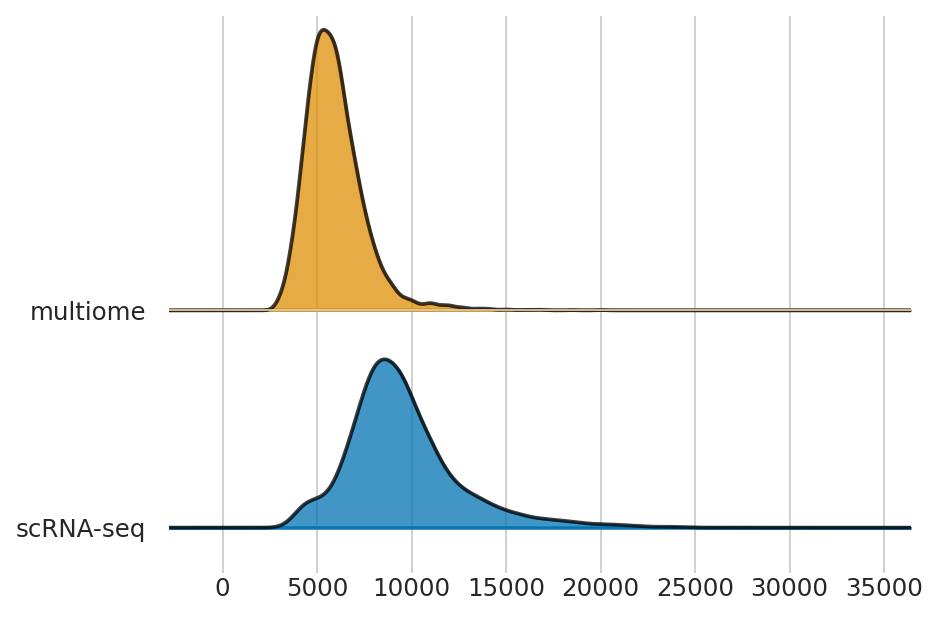

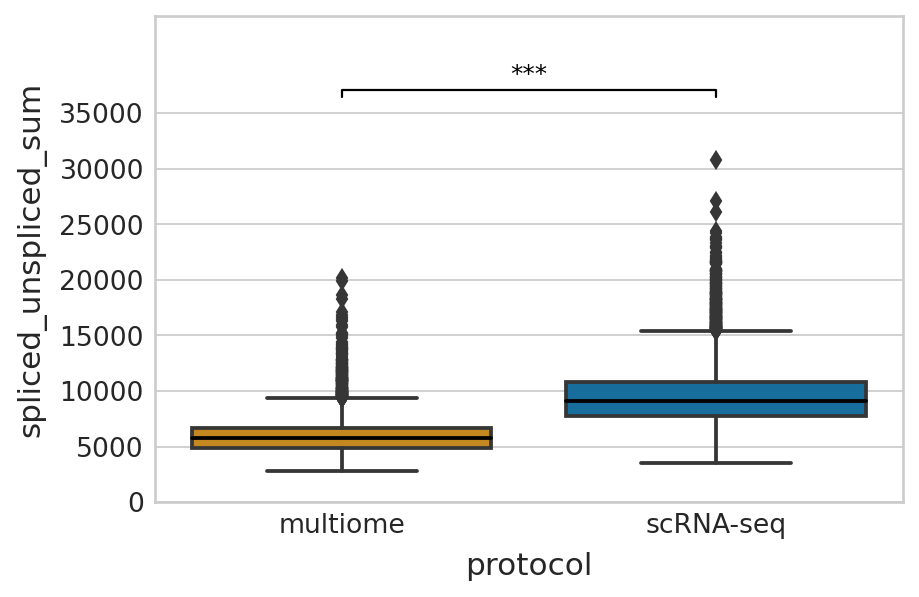

TtestResult(statistic=83.45253952533358, pvalue=0.0, df=8681.372029090475)


In [51]:
# sum of unspliced spliced
adata.layers["spliced_unspliced_sum"] = adata.layers["unspliced"] + adata.layers["spliced"]
df = adata.to_df(layer="spliced_unspliced_sum")
df_sum = pd.DataFrame(df.sum(axis=1), columns=["spliced_unspliced_sum"])
df_sum["protocol"] = adata.obs["protocol"]


datasets = ["multiome", "scRNA-seq"]
palette = dict(zip(df_sum["protocol"].unique(), sns.color_palette("colorblind").as_hex()[:2]))


with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = joypy.joyplot(
        df_sum, by="protocol", color=[palette[dataset] for dataset in datasets], alpha=0.75, figsize=(6, 4), grid="both"
    )
    plt.show()
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "spliced_unspliced_count_densities_e14.5.svg", format="svg", transparent=True, bbox_inches="tight"
        )

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(
        data=df_sum, palette=palette, medianprops={"color": "black"}, x="protocol", y="spliced_unspliced_sum", ax=ax
    )
    ttest_res = ttest_ind(
        df_sum.loc[df_sum["protocol"] == "scRNA-seq", "spliced_unspliced_sum"],
        df_sum.loc[df_sum["protocol"] != "scRNA-seq", "spliced_unspliced_sum"],
        equal_var=False,
        alternative="two-sided",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.15,
        c="k",
        level=0,
    )
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 5000])
    ax.set_yticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000])
    ax.set_yticklabels([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000])
    plt.show()
    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / "sum_count_densities_e14.5_box.svg", format="svg", transparent=True, bbox_inches="tight")

print(ttest_res)

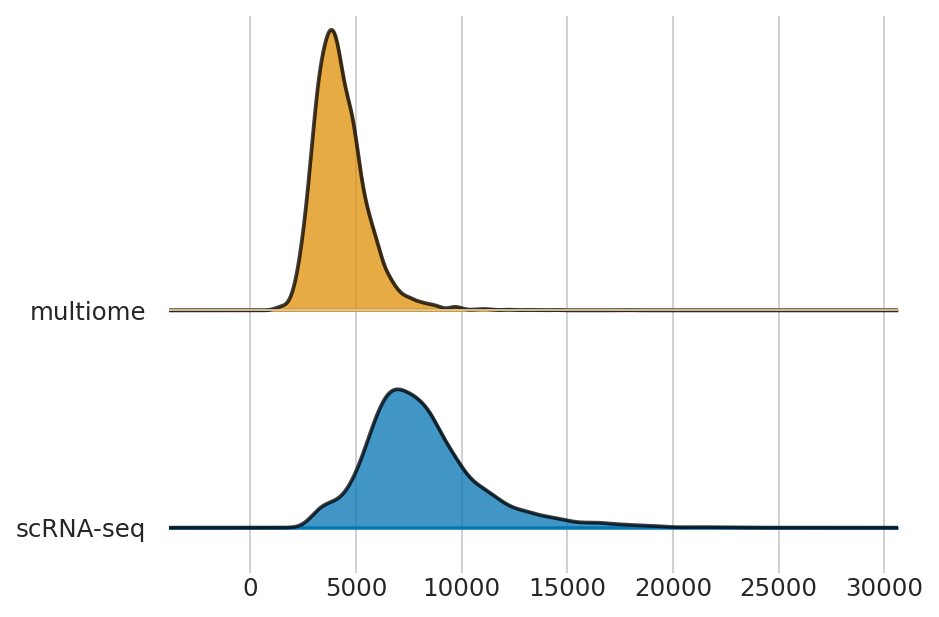

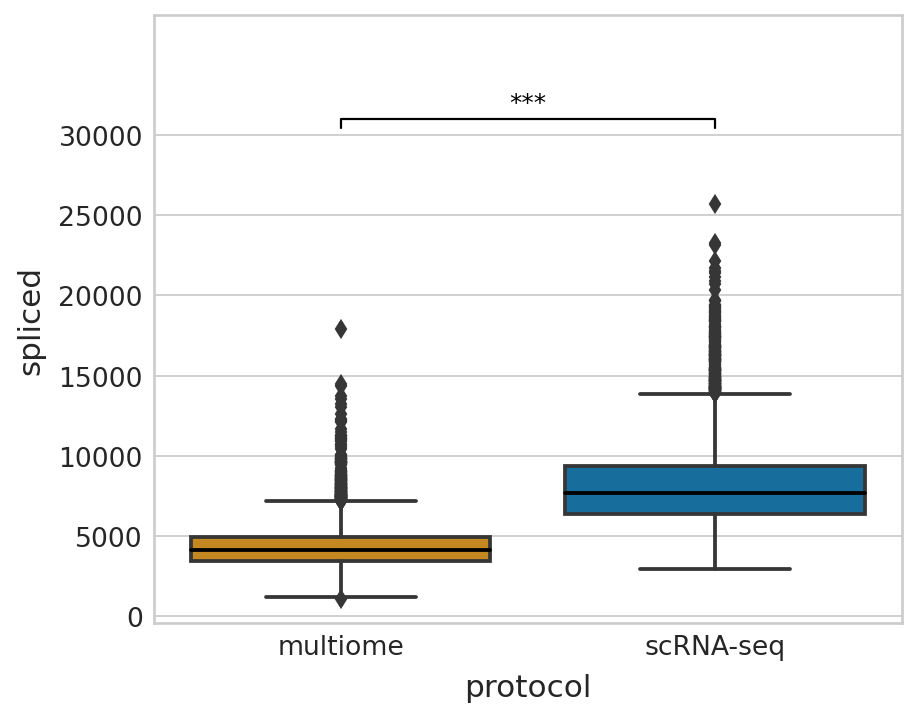

TtestResult(statistic=99.05229394959505, pvalue=0.0, df=8175.6148846895985)


In [52]:
# spliced
df = adata.to_df(layer="spliced")
df_spliced = pd.DataFrame(df.sum(axis=1), columns=["spliced"])
df_spliced["protocol"] = adata.obs["protocol"]

palette = dict(zip(df_spliced["protocol"].unique(), sns.color_palette("colorblind").as_hex()[:2]))

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = joypy.joyplot(
        df_spliced,
        by="protocol",
        color=[palette[dataset] for dataset in datasets],
        alpha=0.75,
        figsize=(6, 4),
        grid="both",
    )
    plt.show()
    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / "spliced_count_densities_e14.5.svg", format="svg", transparent=True, bbox_inches="tight")

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.boxplot(data=df_spliced, palette=palette, medianprops={"color": "black"}, x="protocol", y="spliced", ax=ax)
    ttest_res = ttest_ind(
        df_spliced.loc[df_spliced["protocol"] == "scRNA-seq", "spliced"],
        df_spliced.loc[df_spliced["protocol"] != "scRNA-seq", "spliced"],
        equal_var=False,
        alternative="two-sided",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.15,
        c="k",
        level=0,
    )
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 5000])
    ax.set_yticks(
        [
            0,
            5000,
            10000,
            15000,
            20000,
            25000,
            30000,
        ]
    )
    ax.set_yticklabels(
        [
            0,
            5000,
            10000,
            15000,
            20000,
            25000,
            30000,
        ]
    )
    plt.show()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "spliced_count_densities_e14.5_box.svg", format="svg", transparent=True, bbox_inches="tight"
        )

print(ttest_res)

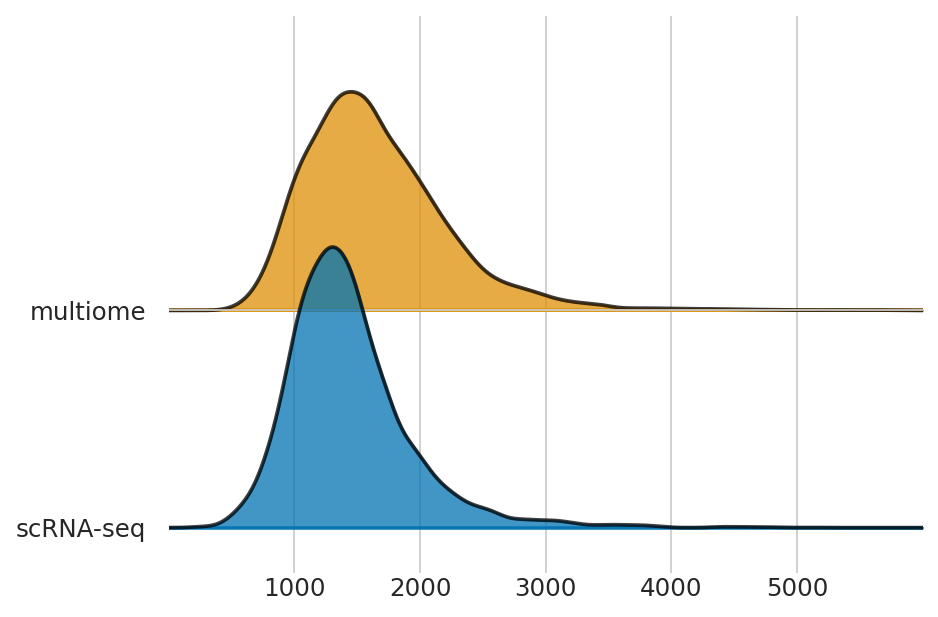

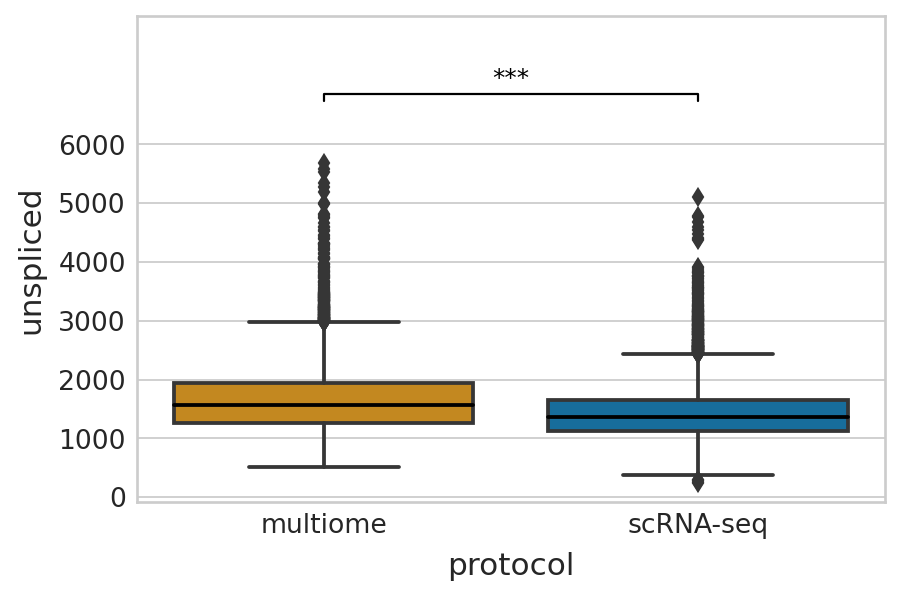

TtestResult(statistic=-23.03183465590363, pvalue=4.229106664202761e-115, df=13118.669733337181)


In [53]:
# unspliced
df = adata.to_df(layer="unspliced")
df_unspliced = pd.DataFrame(df.sum(axis=1), columns=["unspliced"])
df_unspliced["protocol"] = adata.obs["protocol"]

palette = dict(zip(df_unspliced["protocol"].unique(), sns.color_palette("colorblind").as_hex()[:2]))


with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = joypy.joyplot(
        df_unspliced,
        by="protocol",
        color=[palette[dataset] for dataset in datasets],
        alpha=0.75,
        x_range=[0, 6000],
        grid="both",
        figsize=(6, 4),
    )
    plt.show()
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "unspliced_count_densities_e14.5.svg", format="svg", transparent=True, bbox_inches="tight"
        )

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=df_unspliced, palette=palette, medianprops={"color": "black"}, x="protocol", y="unspliced", ax=ax)
    ttest_res = ttest_ind(
        df_unspliced.loc[df_unspliced["protocol"] == "scRNA-seq", "unspliced"],
        df_unspliced.loc[df_unspliced["protocol"] != "scRNA-seq", "unspliced"],
        equal_var=False,
        alternative="two-sided",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.15,
        c="k",
        level=0,
    )
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 1000])
    ax.set_yticks(
        [
            0,
            1000,
            2000,
            3000,
            4000,
            5000,
            6000,
        ]
    )
    ax.set_yticklabels(
        [
            0,
            1000,
            2000,
            3000,
            4000,
            5000,
            6000,
        ]
    )

    plt.show()
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "unspliced_count_densities_e14.5_box.svg", format="svg", transparent=True, bbox_inches="tight"
        )

print(ttest_res)

## Read Data: E15.5

In [54]:
adata_sc = sc.read(PROJECT_DIR / "pancreas_sc" / "processed" / "gex_e15.5.h5ad")
adata_sn = sc.read(PROJECT_DIR / "pancreas_multiome" / "processed" / "gex_e15.5.h5ad")

adata = ad.concat([adata_sc, adata_sn])

## Joyplots of sum of unspliced and spliced counts


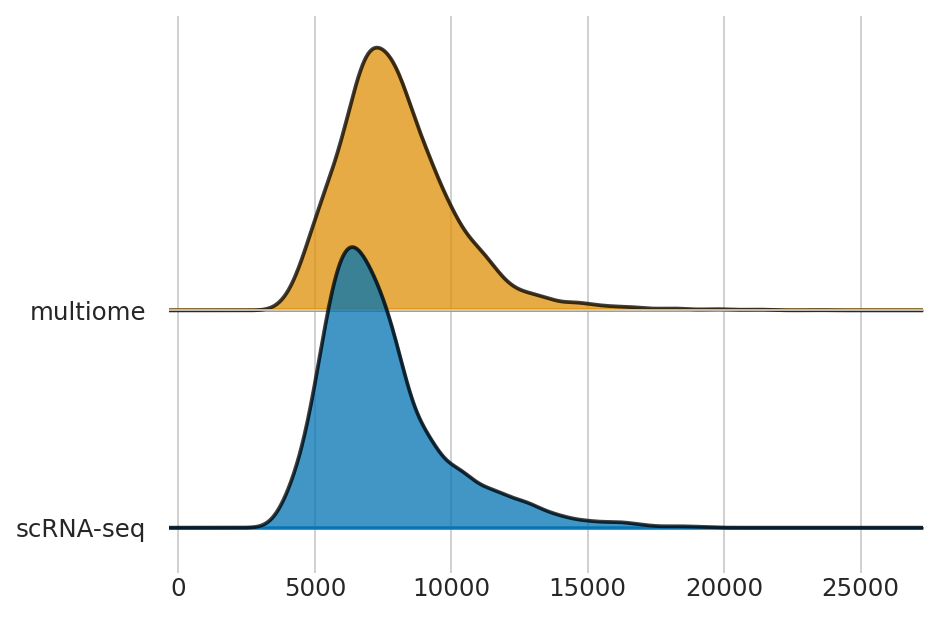

TtestResult(statistic=-10.073137357848045, pvalue=1.014873674504105e-23, df=7775.292744653667)


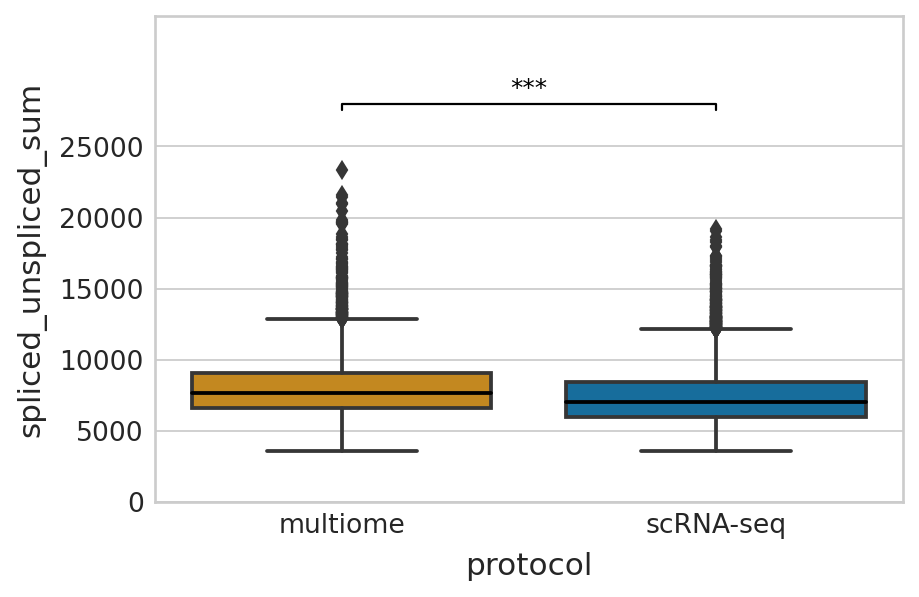

In [55]:
# sum of unspliced spliced
adata.layers["spliced_unspliced_sum"] = adata.layers["unspliced"] + adata.layers["spliced"]
df = adata.to_df(layer="spliced_unspliced_sum")
df_sum = pd.DataFrame(df.sum(axis=1), columns=["spliced_unspliced_sum"])
df_sum["protocol"] = adata.obs["protocol"]


datasets = ["multiome", "scRNA-seq"]
palette = dict(zip(df_sum["protocol"].unique(), sns.color_palette("colorblind").as_hex()[:2]))


with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = joypy.joyplot(
        df_sum, by="protocol", color=[palette[dataset] for dataset in datasets], alpha=0.75, figsize=(6, 4), grid="both"
    )
    plt.show()
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "spliced_unspliced_count_densities_e15.5.svg", format="svg", transparent=True, bbox_inches="tight"
        )

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(
        data=df_sum, palette=palette, medianprops={"color": "black"}, x="protocol", y="spliced_unspliced_sum", ax=ax
    )
    ttest_res = ttest_ind(
        df_sum.loc[df_sum["protocol"] == "scRNA-seq", "spliced_unspliced_sum"],
        df_sum.loc[df_sum["protocol"] != "scRNA-seq", "spliced_unspliced_sum"],
        equal_var=False,
        alternative="two-sided",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.15,
        c="k",
        level=0,
    )
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 5000])
    ax.set_yticks(
        [
            0,
            5000,
            10000,
            15000,
            20000,
            25000,
        ]
    )
    ax.set_yticklabels(
        [
            0,
            5000,
            10000,
            15000,
            20000,
            25000,
        ]
    )

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / "sum_count_densities_e15.5_box.svg", format="svg", transparent=True, bbox_inches="tight")

print(ttest_res)

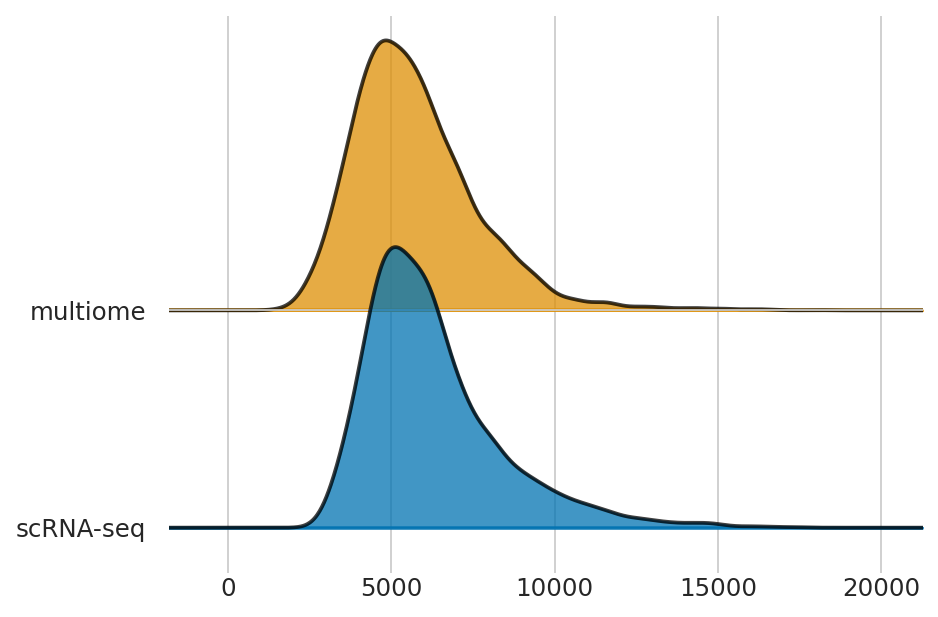

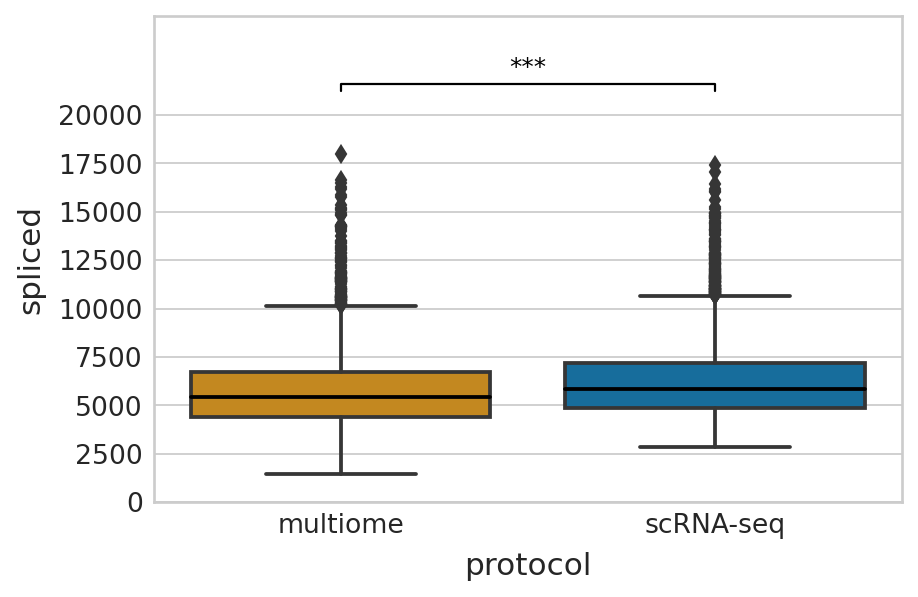

TtestResult(statistic=12.399353652510742, pvalue=5.718388131904213e-35, df=7621.474611448745)


In [56]:
# spliced
df = adata.to_df(layer="spliced")
df_spliced = pd.DataFrame(df.sum(axis=1), columns=["spliced"])
df_spliced["protocol"] = adata.obs["protocol"]

palette = dict(zip(df_spliced["protocol"].unique(), sns.color_palette("colorblind").as_hex()[:2]))

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = joypy.joyplot(
        df_spliced,
        by="protocol",
        color=[palette[dataset] for dataset in datasets],
        alpha=0.75,
        figsize=(6, 4),
        grid="both",
    )
    plt.show()
    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / "spliced_count_densities_e15.5.svg", format="svg", transparent=True, bbox_inches="tight")

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=df_spliced, palette=palette, medianprops={"color": "black"}, x="protocol", y="spliced", ax=ax)
    ttest_res = ttest_ind(
        df_spliced.loc[df_spliced["protocol"] == "scRNA-seq", "spliced"],
        df_spliced.loc[df_spliced["protocol"] != "scRNA-seq", "spliced"],
        equal_var=False,
        alternative="two-sided",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.15,
        c="k",
        level=0,
    )
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 2500])
    ax.set_yticks(
        [
            0,
            2500,
            5000,
            7500,
            10000,
            12500,
            15000,
            17500,
            20000,
        ]
    )
    ax.set_yticklabels(
        [
            0,
            2500,
            5000,
            7500,
            10000,
            12500,
            15000,
            17500,
            20000,
        ]
    )
    plt.show()
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "spliced_count_densities_e15.5_box.svg", format="svg", transparent=True, bbox_inches="tight"
        )

print(ttest_res)

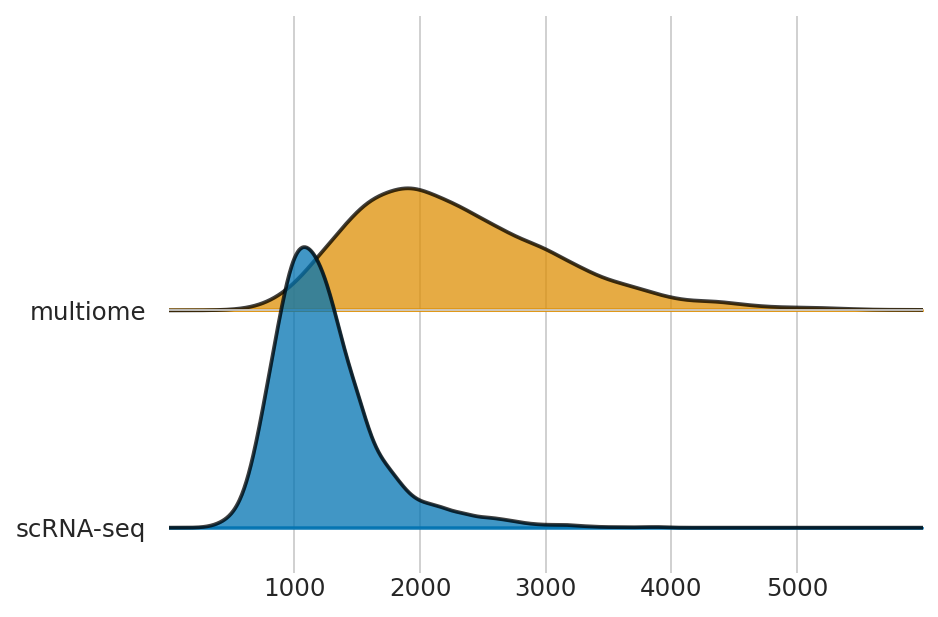

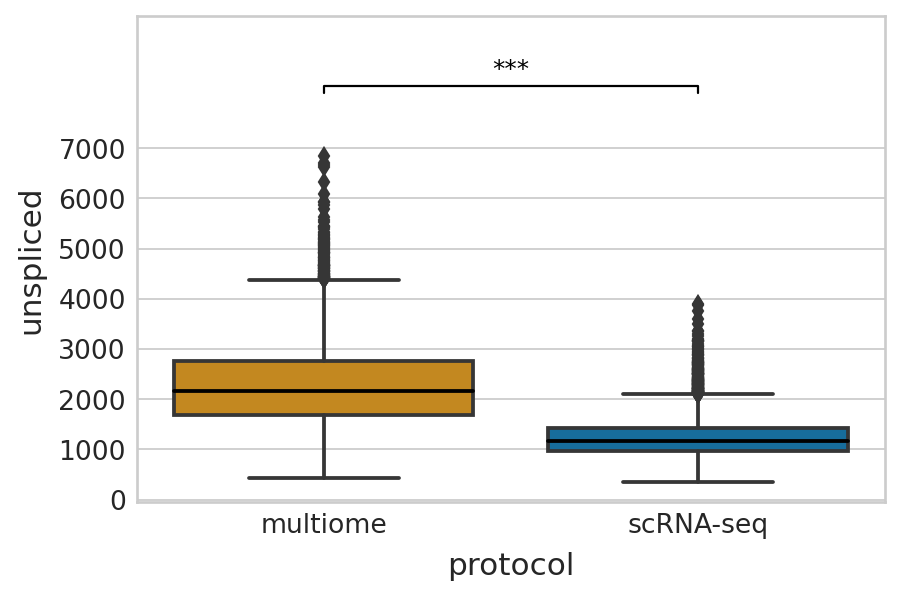

TtestResult(statistic=-75.26497070526007, pvalue=0.0, df=7343.453442558367)


In [57]:
# unspliced
df = adata.to_df(layer="unspliced")
df_unspliced = pd.DataFrame(df.sum(axis=1), columns=["unspliced"])
df_unspliced["protocol"] = adata.obs["protocol"]

palette = dict(zip(df_unspliced["protocol"].unique(), sns.color_palette("colorblind").as_hex()[:2]))


with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = joypy.joyplot(
        df_unspliced,
        by="protocol",
        color=[palette[dataset] for dataset in datasets],
        alpha=0.75,
        x_range=[0, 6000],
        grid="both",
        figsize=(6, 4),
    )
    plt.show()
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "unspliced_count_densities_e15.5.svg", format="svg", transparent=True, bbox_inches="tight"
        )

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=df_unspliced, palette=palette, medianprops={"color": "black"}, x="protocol", y="unspliced", ax=ax)
    ttest_res = ttest_ind(
        df_unspliced.loc[df_unspliced["protocol"] == "scRNA-seq", "unspliced"],
        df_unspliced.loc[df_unspliced["protocol"] != "scRNA-seq", "unspliced"],
        equal_var=False,
        alternative="two-sided",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.15,
        c="k",
        level=0,
    )
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 1000])
    ax.set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax.set_yticklabels([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000])

    plt.show()
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "unspliced_count_densities_e15.5_box.svg", format="svg", transparent=True, bbox_inches="tight"
        )
print(ttest_res)